# Yêu cầu:
1.download bộ data nhận dạng gương mặt người nổi tiếng từ link: https://drive.google.com/file/d/1kpxjaz3pIMrAhEjm7hJxcBsxKNhfl8t2/view
2. Biến mỗi gương mặt thành embedding sử dụng GhostFaceNet
3. Dùng Faiss và các embedding thu được để nhận diện gương mặt , áp dụng kĩ thuật Enhancement để tăng hiệu quả.
4. Visualize , đánh giá kết quả

# Face Recognition Using GhostFaceNet (Part II)

## A Jupyter notebook face attendance system

## Implement Mean Face Enhancement Method

### Suppose a User submit 2 new face images into the system, Add them to the current saved embedding by first aggregation these 2 images into a single image embeddings

In [4]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 21.5 MB/s eta 0:00:00


In [5]:
import faiss
import numpy as np

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc

In [39]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Step 0 : đọc Embedding vectors (4720 vector), identity và tên của từng ảnh trong dataset

In [26]:
aa = np.load("/content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/root_embs/vn2.npz")
embs, imm_classes, filename = aa["embs"], aa["imm_classes"], aa["filenames"]
emb, img_class = embs.astype("float32"), imm_classes.astype("int")
print(emb.shape)
dimensions = 512 #FaceNet output is 128 dimensional vector

metric = 'cosine' #euclidean, cosine

if metric == 'euclidean':
    index = faiss.IndexFlatL2(dimensions)
elif metric == 'cosine':
    index = faiss.IndexFlatIP(dimensions)
    # faiss.normalize_L2(emb)

(4720, 512)


In [ ]:
!pip install tensorflow

### Step 1: Face Detection

Tiến hành unzip các ảnh dùng để test, các ảnh này hoàn toàn chụp trên môi trường tự nhiên

In [8]:
!cp /content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/test_cases.zip test_cases.zip
!unzip test_cases.zip -d test_cases

Archive:  test_cases.zip
  inflating: test_cases/anh-hung-trung-tuong-pham-tuan-1.jpg  
  inflating: test_cases/bb39.jpg     
  inflating: test_cases/dsc08351_pryc.jpg  
  inflating: test_cases/hinh-anh-kha-banh-trai-tim.jpg  
  inflating: test_cases/hqdefault.jpg  
  inflating: test_cases/huan-hoa-hong-su-dung-cac-phat-ngon-viral-gay-soc-de-tao-do-noi-cho-ban-than.png  
  inflating: test_cases/IMG-9345-JPG-2462-1573620580.jpg  
  inflating: test_cases/k-banh-160854040659129941883.jpg  
  inflating: test_cases/khabanh1-15548600544621702844906-crop-155486009131555711973-1554862590420346370649.png  
  inflating: test_cases/portrait.jpg  
  inflating: test_cases/portrait2.jpg  
  inflating: test_cases/Son-Tung-Dep-Trai-5..jpg  
  inflating: test_cases/test3.jpg    
  inflating: test_cases/unnamed.jpg  
  inflating: test_cases/untitled-3-1660097402-436-width640height480_schema_article.jpg  
  inflating: test_cases/vov_pham_tuan_1_lthn.jpg  


In [10]:
!cp /content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/face_detector.py face_detector.py
# copy file model face detection


## Crop face trong các ảnh test

In [11]:
from face_detector import YoloV5FaceDetector
folder_raw_face = "test_cases/"
data_path = YoloV5FaceDetector().detect_in_folder(folder_raw_face)

181100504/181100504 [==============================] - 10s 0us/step


Detecting: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]

>>>> Saved aligned face images in: test_cases_aligned_112_112


## Step 2: Create Face Embeddings

In [12]:
class Eval_image:
    def __init__(self, model_interf, img_path, output_dir,root_img_path):
        print(model_interf)
        if isinstance(model_interf, str) and model_interf.endswith("h5"):
            model = tf.keras.models.load_model(model_interf)
            self.model_interf = lambda imms: model((imms - 127.5) * 0.0078125).numpy()
        else:
            self.model_interf = model_interf
        self.dist_func = lambda aa, bb: np.dot(aa, bb)
        self.output_dir = output_dir
        self.img_path = img_path
        print('begin serving')
        self.root_path = root_img_path
        self.embs, self.imm_classes, self.filenames = self.prepare_image_and_embedding(self.img_path, self.output_dir)

    def prepare_image_and_embedding(self, img_folder, output_dir):
        save_embeddings = output_dir
        if save_embeddings and os.path.exists(save_embeddings):
            print(">>>> Reloading from backup:", save_embeddings)
            aa = np.load(save_embeddings)
            embs, imm_classes, filename = aa["embs"], aa["imm_classes"], aa["filenames"]
            emb, img_class = embs.astype("float32"), imm_classes.astype("int")
        else:
            img_shape = (112, 112)
            imgs = pd.read_csv('train.csv')['image'].tolist()
            labels = pd.read_csv('train.csv')['label'].tolist()
            embs = [] # list of embeddings
            classes = []
            names = []
            for i,img_path in enumerate(tqdm(imgs)):
                img_path = os.path.join(self.root_path,img_path)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = np.expand_dims(img, axis=0)

                emb = self.model_interf(img)
                emb = normalize(np.array(emb).astype("float32"))[0]
                img_class = int(labels[i])
                classes.append(img_class)
                embs.append(emb)
                filename = os.path.basename(img_path)
                names.append(filename)

            np.savez(output_dir, embs=embs, imm_classes=classes, filenames=names)

        return emb, img_class, filename



    def do_evaluation(self):
        register_ids = np.unique(self.imm_classes)
        print(">>>> [base info] embs:", self.embs.shape, "imm_classes:", self.imm_classes.shape, "register_ids:", register_ids.shape)

        register_base_embs = np.array([]).reshape(0, self.embs.shape[-1])
        register_base_dists = []
        for register_id in tqdm(register_ids, "Evaluating"):
            pos_pick_cond = self.imm_classes == register_id
            pos_embs = self.embs[pos_pick_cond]
            register_base_emb = normalize([np.sum(pos_embs, 0)])[0]

            register_base_dist = self.dist_func(self.embs, register_base_emb)
            register_base_dists.append(register_base_dist)
            register_base_embs = np.vstack([register_base_embs, register_base_emb])
        register_base_dists = np.array(register_base_dists).T
        # cosine similarity from one image to each class
        print(register_base_dists.shape)
        accuracy = (register_base_dists.argmax(1) == self.imm_classes).sum() / register_base_dists.shape[0]
        print("register_ids shape: ",register_ids.shape)
        print("self.imm_classes shape: ",self.imm_classes.shape)
        reg_pos_cond = np.equal(register_ids, np.expand_dims(self.imm_classes, 1))
        print(reg_pos_cond.shape) # array co 1 nghin cot, gia tri tai cot label =1

        reg_pos_dists = register_base_dists[reg_pos_cond].ravel()
        print(reg_pos_dists.shape)
        reg_neg_dists = register_base_dists[np.logical_not(reg_pos_cond)].ravel()
        print(reg_neg_dists.shape)
        label = np.concatenate([np.ones_like(reg_pos_dists), np.zeros_like(reg_neg_dists)])
        score = np.concatenate([reg_pos_dists, reg_neg_dists]) #distance tai cot co label va k co label
        return accuracy,score,label

def plot_tpr_far(score, label, new_figure=True, label_prefix=""):
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)

    fpr_show = [10 ** (-ii) for ii in range(1, 7)[::-1]]
    fpr_reverse, tpr_reverse = fpr[::-1], tpr[::-1]
    tpr_show = [tpr_reverse[np.argmin(abs(fpr_reverse - ii))] for ii in fpr_show]
    print(pd.DataFrame({"FPR": fpr_show, "TPR": tpr_show}).set_index("FPR").T.to_markdown())

    try:
        import matplotlib.pyplot as plt

        fig = plt.figure() if new_figure else None
        label = "AUC = %0.4f%%" % (roc_auc * 100)
        if label_prefix and len(label_prefix) > 0:
            label = label_prefix + " " + label
        plt.plot(fpr, tpr, lw=1, label=label)
        plt.xlim([10 ** -6, 0.1])
        plt.xscale("log")
        plt.xticks(fpr_show)
        plt.xlabel("False Positive Rate")
        plt.ylim([0, 1.0])
        plt.yticks(np.linspace(0, 1.0, 8, endpoint=True))
        plt.ylabel("True Positive Rate")

        plt.grid(linestyle="--", linewidth=1)
        plt.title("ROC")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except:
        print("matplotlib plot failed")
        fig = None
    return fig

In [15]:
demo_image = Eval_image("/content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/GhostFaceNet_W1.3_S1_ArcFace.h5", "./VN-celeb", output_dir="/content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/root_embs/vn2.npz",root_img_path="/content/VN-celeb")

/content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/GhostFaceNet_W1.3_S1_ArcFace.h5


begin serving
>>>> Reloading from backup: /content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/root_embs/vn2.npz


In [16]:
mean_embss = np.load("/content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/root_embs/processed_embedding.npz")['embs']
 # load 1000 vector đại diện cho 1000 identity

In [17]:
## add a new person's embedding using some image
imgs = ["/content/test_cases_aligned_112_112/portrait2.jpg","/content/test_cases_aligned_112_112/portrait.jpg"]
personal_embeddings = np.array([]).reshape(0, 512)
for img_path in imgs:
    # đọc và resize ảnh về kích thước 112,112
    img = cv2.imread(img_path)
    img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    # single embeeding
    semb = demo_image.model_interf(img)
    # normalize từng embedding vector
    semb = normalize(np.array(semb).astype("float32"))[0]
    # lưu toàn bộ embedding vector vào 1 numpy array
    personal_embeddings = np.vstack([personal_embeddings, semb])
# tạo vector đại diện bằng cách tổng hợp các vector embedding đang có
p_pos_embs = personal_embeddings
p_register_base_emb = normalize([np.sum(p_pos_embs, 0)])[0]
# gắn vector đại diện mới vào danh sách các vector đại diện đang có
normalized_embeddings_new = np.vstack([mean_embss.copy(), p_register_base_emb])
print(normalized_embeddings_new.shape)

(1001, 512)


In [ ]:
imm_classes # image to class int

array([399, 881, 708, ..., 552, 212, 326], dtype=int64)

In [ ]:
filename.shape

(4720,)

## Step 3: Adding new label and filenames to the system

In [27]:
## add new info
## add thêm 2 ảnh => thêm 2 label mới vào danh sách 4720 label đang có
imm_classes_new = np.append(imm_classes, 1000)
imm_classes_new = np.append(imm_classes_new, 1000)
## add thêm 2 ảnh => thêm 2 file name mới vào danh sách 4720 file name đang có

filename_new = np.append(filename, imgs[0])
filename_new = np.append(filename_new, imgs[1])


## Step 4: EMbedding the Query Image

In [19]:
img = cv2.imread("/content/test_cases_aligned_112_112/test3.jpg")
img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
# single embeeding
semb = demo_image.model_interf(img)
semb = normalize(np.array(semb).astype("float32"))[0]

In [ ]:
# register_ids = np.unique(imm_classes)
# mean_embss = np.load("processed_embedding.npz")['embs']

## Như vậy, chúng ta có thể tăng tốc độ tìm kiếm bằng cách : chỉ so sánh ảnh query với 1001 vector đại diện thay vì so sánh với 4720+2 vector hình ảnh như phương pháp trước đây

## Dùng faiss để so sánh

In [22]:
index.add(normalized_embeddings_new.astype(np.float32))

In [23]:
k = 1
target_representation = np.array(semb, dtype='f')
target_representation = np.expand_dims(target_representation, axis=0)
distances, neighbors = index.search(target_representation, k)

## Step 5: Visualizing the search results for the newly added person

In [24]:
distances[0]

array([0.5356018], dtype=float32)

[1000]
[[4720]
 [4721]]


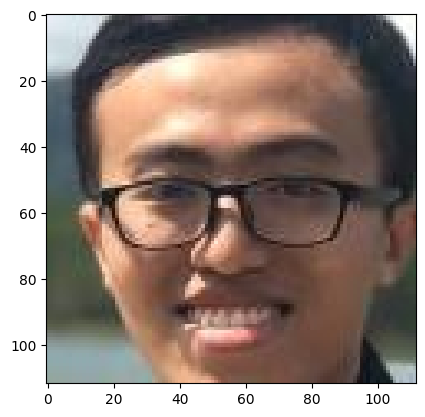

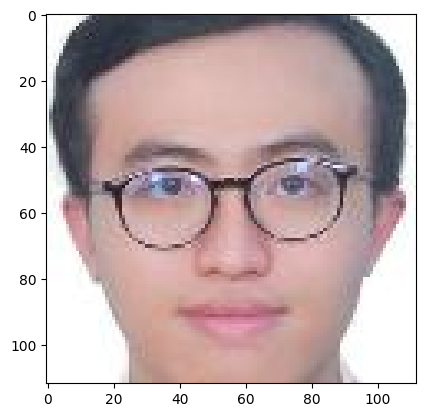

In [28]:
id_list = np.argwhere(imm_classes_new == neighbors.tolist()[0])
print("Ảnh query khớp với identity có id = ",neighbors.tolist()[0])
from matplotlib import pyplot as plt
plt.subplot(1,3,1)
plt.imshow(img)
for i in id_list:
    im  = plt.imread(filename_new[i][0])
    plt.imshow(im)
    plt.show()

In [31]:
filename_new

array(['10b36d309a0c4baeafe312e55355ef47.png',
       '18d2f368513a4abc93122047044aec08.png',
       '24bf4e543ad247f38cafb8129b586e34.png', ...,
       'ef37147f042548eaa613b7b3efac306c.png',
       '/content/test_cases_aligned_112_112/portrait2.jpg',
       '/content/test_cases_aligned_112_112/portrait.jpg'], dtype='<U49')

## Question 2: Test the face recognition model for some people in the current dataset: Sơn tùng, xuân hinh, xuân bắc, phạm tuân...

In [45]:
!cp /content/drive/MyDrive/LDS8_new_content/b9_face_recognition_p2/data/train.zip train.zip
!unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/0001ede029cd4018a5470da6624ac253.png  
  inflating: train/000dc5578cf64e97b88e30c657083f6e.png  
  inflating: train/00210b5b3053449ba58a4656b40ae899.png  
  inflating: train/00269d26afcf46859f17f6bf7570a045.png  
  inflating: train/002d99a32ad04c13a21d13bf2889c471.png  
  inflating: train/003092502e9d4fbaa86f53f335405019.png  
  inflating: train/004292adbcae42ba87d35debd0233eef.png  
  inflating: train/004a715810774807a7418d1dc6c30e88.png  
  inflating: train/004ff50165594dbe8b0292cf881b8abc.png  
  inflating: train/00576a695ac84834aafe9d3020edfa7f.png  
  inflating: train/0060df6884994a33b3d4b99e7f3792bb.png  
  inflating: train/006b81b653374d16ac8e8c5f46e77599.png  
  inflating: train/006e585d392e458abb7957581c503342.png  
  inflating: train/0074c8fbe4094784b7a91df878fe8ba6.png  
  inflating: train/00855f3e0bbd4ca2b991289f5cc8cd77.png  
  inflating: train/00924c61296e49639615a4e4ffbc93c6.png  
  inflating: train/009997f67d164

In [46]:
img = cv2.imread("/content/test_cases_aligned_112_112/Son-Tung-Dep-Trai-5..jpg")
img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
# single embeeding
semb = demo_image.model_interf(img)
semb = normalize(np.array(semb).astype("float32"))[0]

In [49]:
index.add(normalized_embeddings_new.astype(np.float32))

In [51]:
k = 1
target_representation = np.array(semb, dtype='f')
target_representation = np.expand_dims(target_representation, axis=0)
distances, neighbors = index.search(target_representation, k)

Identity của ảnh =  [707]
Các ảnh trong dataset: 


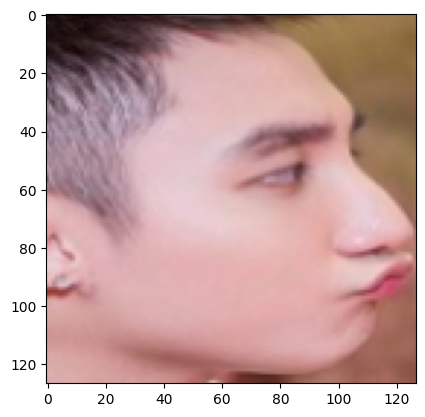

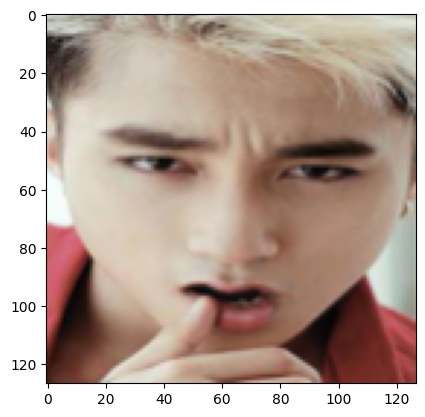

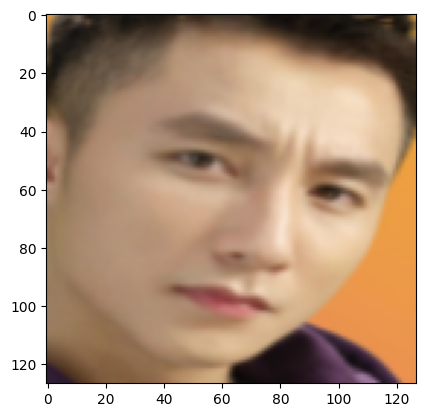

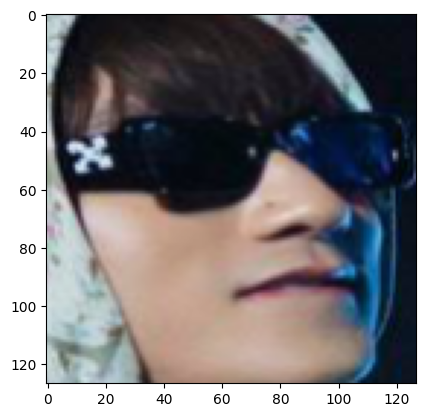

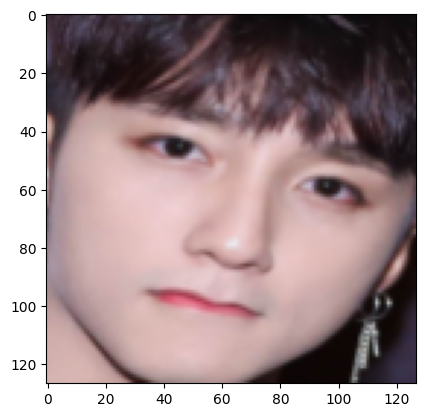

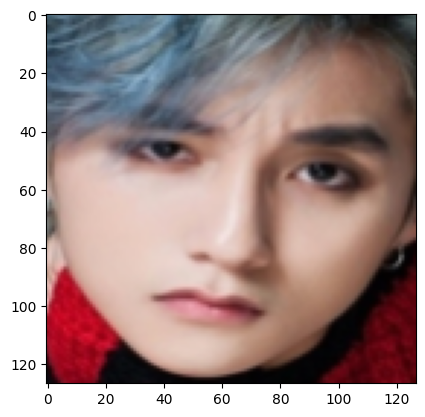

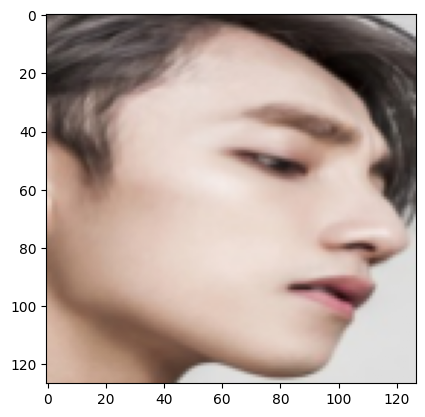

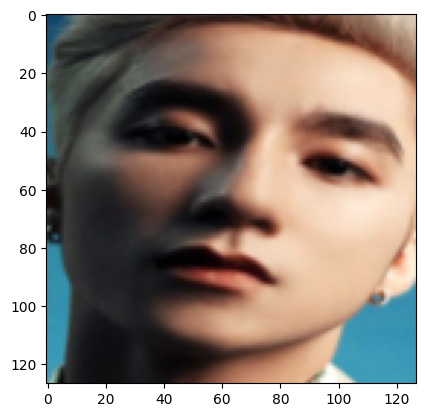

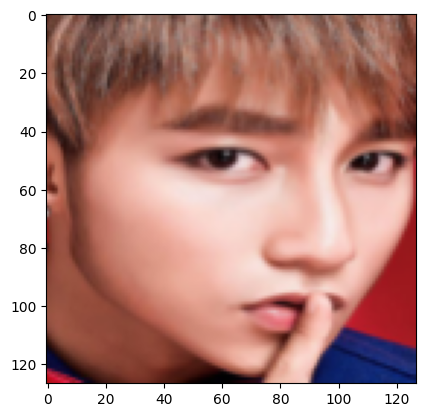

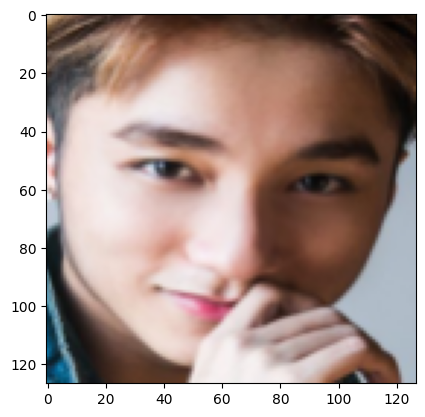

In [54]:
id_list = np.argwhere(imm_classes_new == neighbors.tolist()[0])
print("Identity của ảnh = ",neighbors.tolist()[0])
print("Các ảnh trong dataset: ")
from matplotlib import pyplot as plt
for i in id_list:
    im  = plt.imread("train/"+filename_new[i][0])
    plt.imshow(im)
    plt.show()

# More Face Recognition Results from VNCELEB dataset

In [58]:
img = cv2.imread("/content/test_cases_aligned_112_112/vov_pham_tuan_1_lthn.jpg")
img = cv2.resize(img, (112,112), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
# single embeeding
semb = demo_image.model_interf(img)
semb = normalize(np.array(semb).astype("float32"))[0]

In [59]:
k = 1
target_representation = np.array(semb, dtype='f')
target_representation = np.expand_dims(target_representation, axis=0)
distances, neighbors = index.search(target_representation, k)

Identity của ảnh =  [675]
Các ảnh trong dataset: 


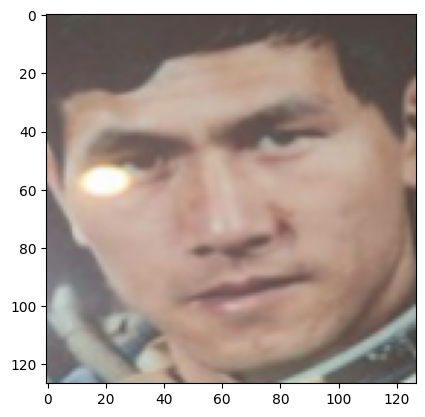

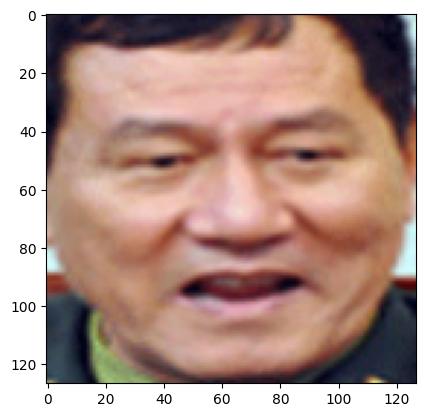

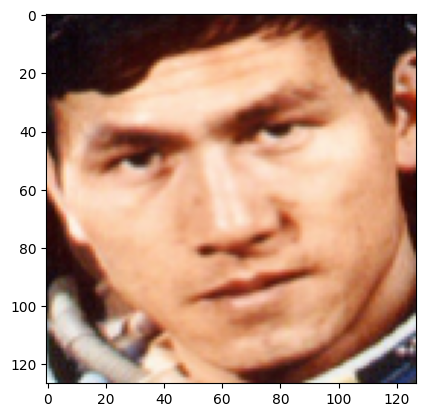

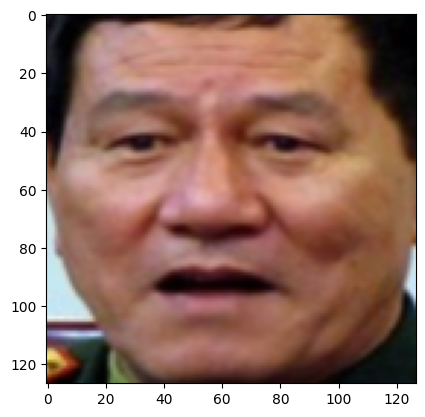

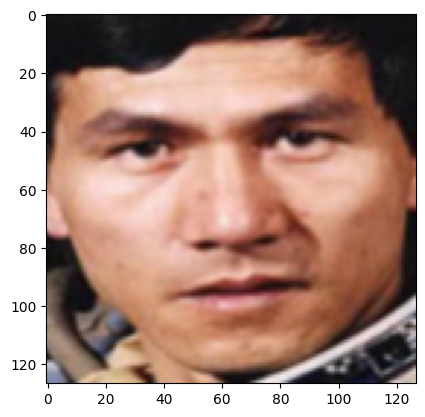

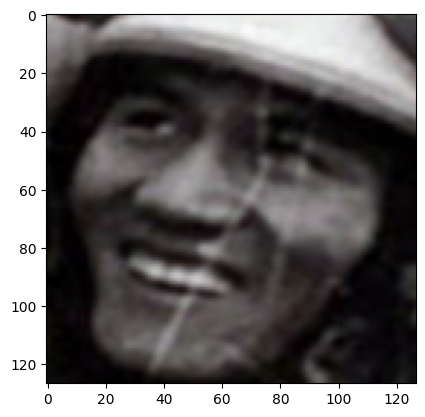

In [60]:
id_list = np.argwhere(imm_classes_new == neighbors.tolist()[0])
print("Identity của ảnh = ",neighbors.tolist()[0])
print("Các ảnh trong dataset: ")
from matplotlib import pyplot as plt
for i in id_list:
    im  = plt.imread("train/"+filename_new[i][0])
    plt.imshow(im)
    plt.show()

# Many More Examples...

[707]
[[ 764]
 [1507]
 [1578]
 [2029]
 [2067]
 [2322]
 [2386]
 [2690]
 [3213]
 [3756]]


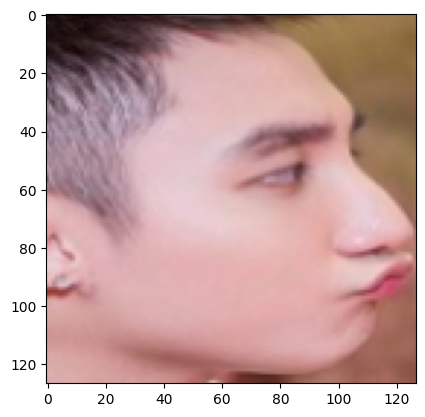

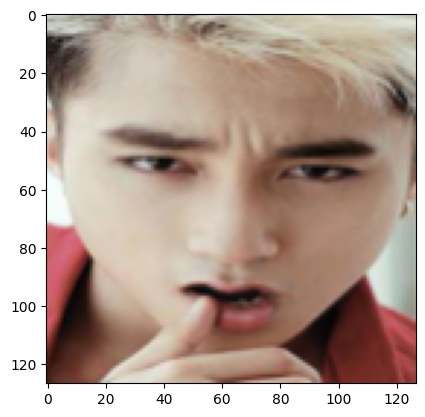

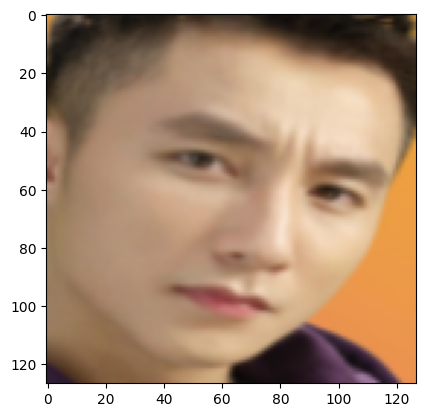

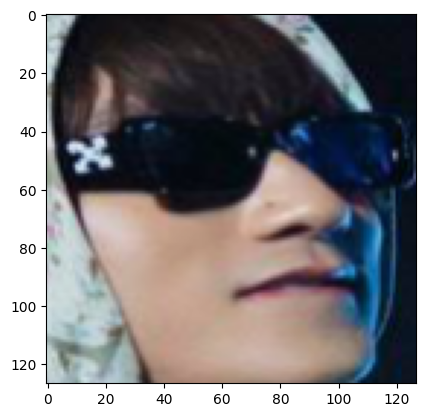

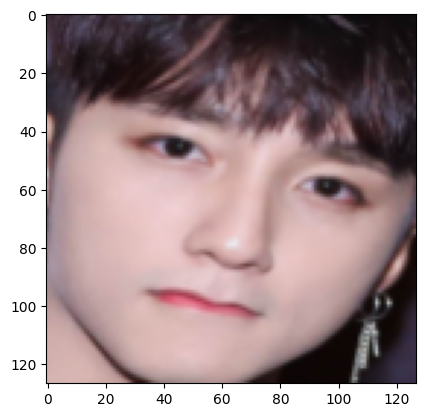

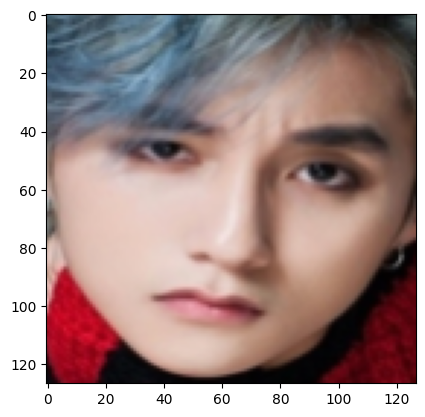

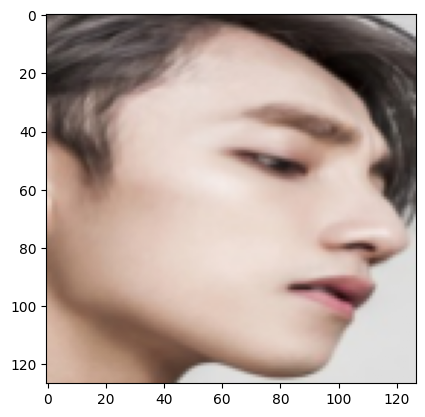

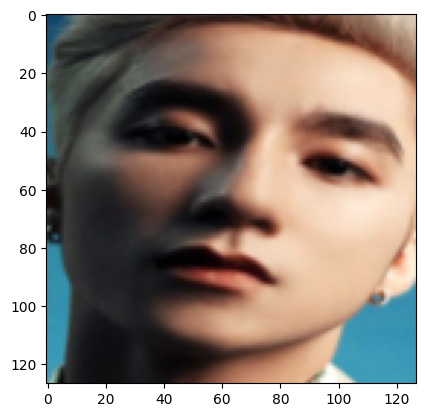

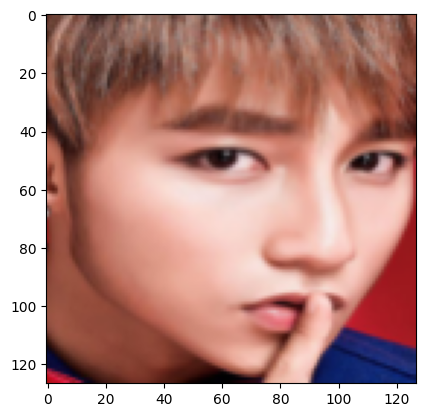

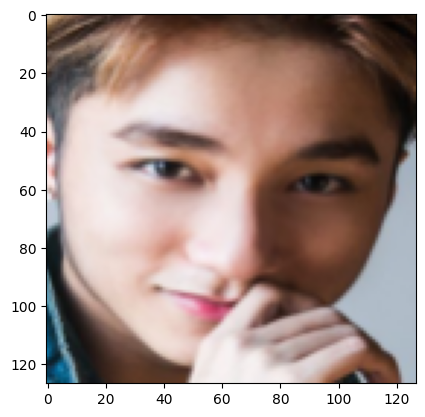

In [ ]:
id_list = np.argwhere(imm_classes_new == neighbors.tolist()[0])
print(neighbors.tolist()[0])
print(id_list)
from matplotlib import pyplot as plt
for i in id_list:
    im  = plt.imread("train/" + filename_new[i][0])
    plt.imshow(im)
    plt.show()

[908]
[[1280]
 [1495]
 [1550]
 [1814]
 [2112]
 [3274]
 [3960]
 [4508]]


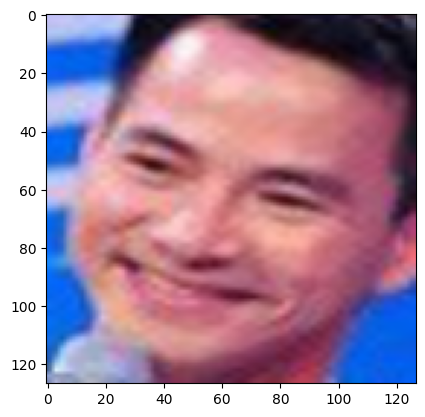

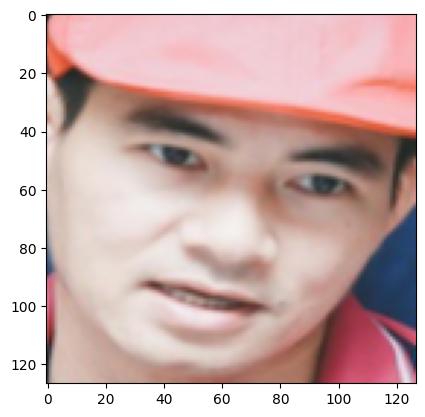

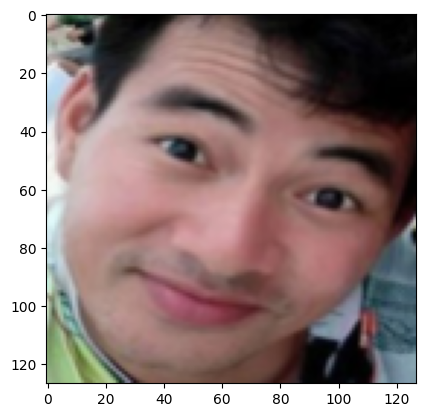

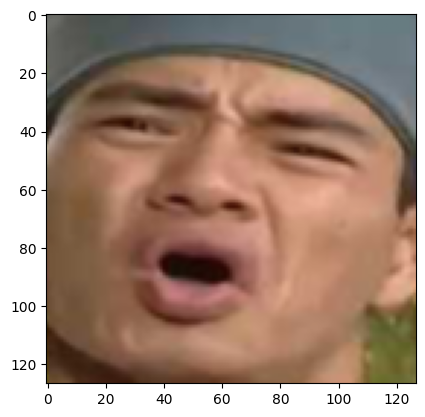

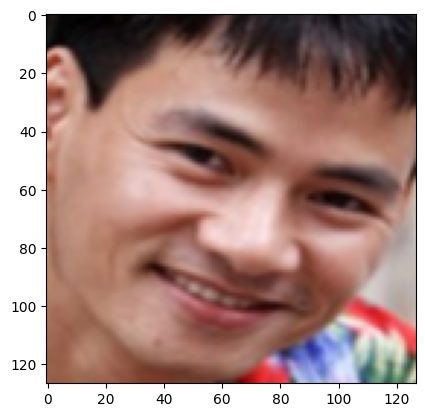

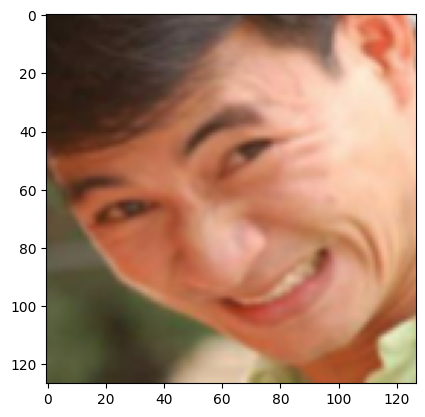

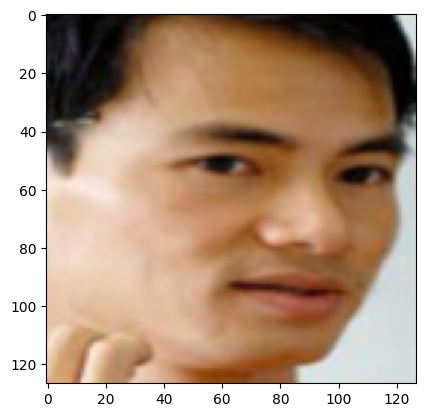

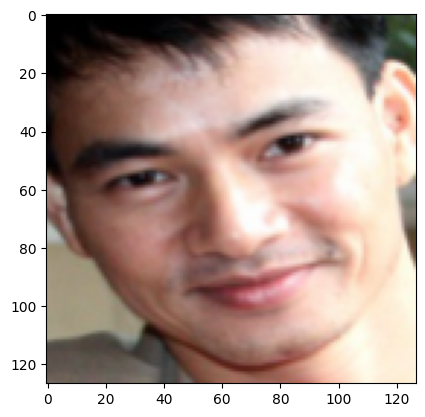

In [ ]:
imm_classes == neighbors.tolist()[0]
id_list = np.argwhere(imm_classes == neighbors.tolist()[0])
print(neighbors.tolist()[0])
print(id_list)
from matplotlib import pyplot as plt
for i in id_list:
    im  = plt.imread("train/"+filename[i][0])
    plt.imshow(im)
    plt.show()

[675]
[[1442]
 [2136]
 [2389]
 [3569]
 [4056]
 [4502]]


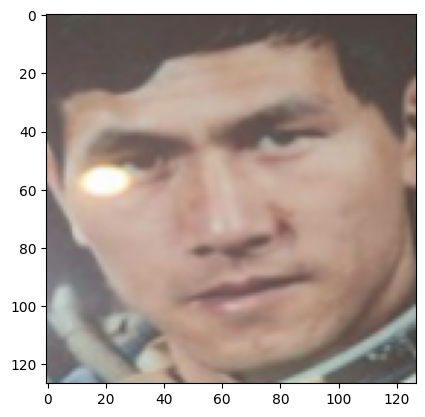

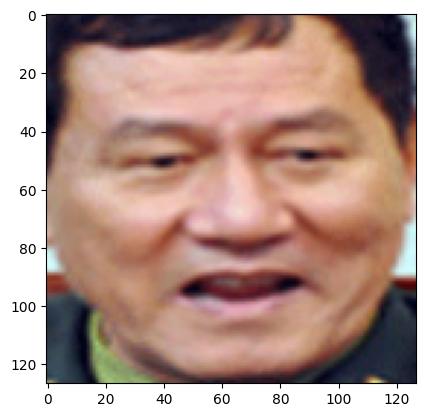

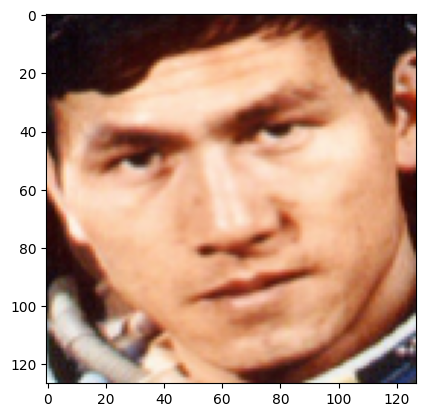

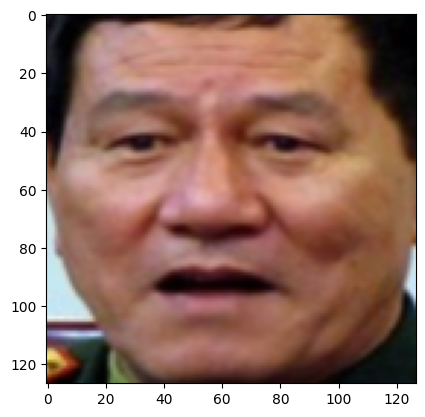

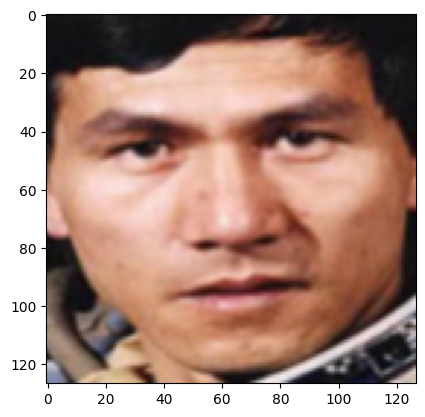

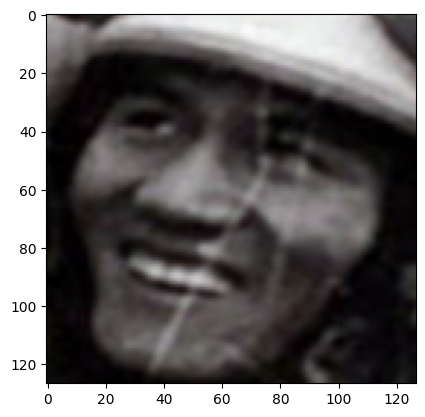

In [ ]:
imm_classes == neighbors.tolist()[0]
id_list = np.argwhere(imm_classes == neighbors.tolist()[0])
print(neighbors.tolist()[0])
print(id_list)
from matplotlib import pyplot as plt
for i in id_list:
    im  = plt.imread("train/"+filename[i][0])
    plt.imshow(im)
    plt.show()

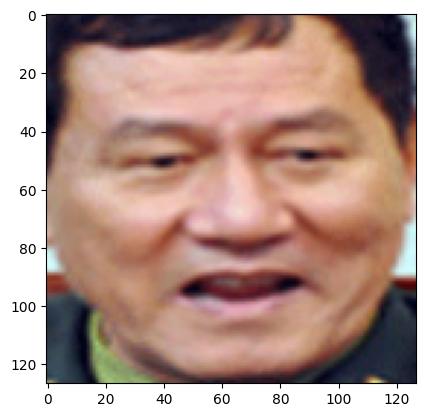

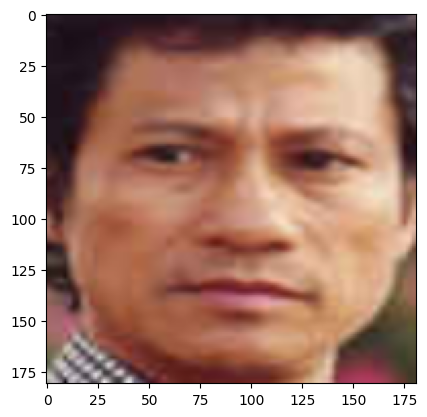

In [ ]:
id_list = neighbors.tolist()[0]
from matplotlib import pyplot as plt
for i in id_list:
    im  = plt.imread("train/"+filename[i])
    plt.imshow(im)
    plt.show()

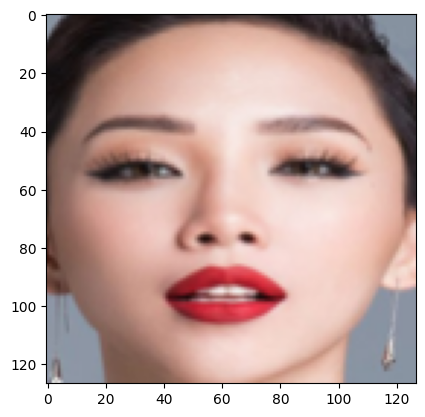

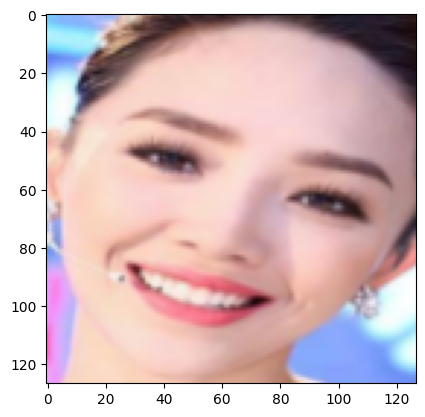

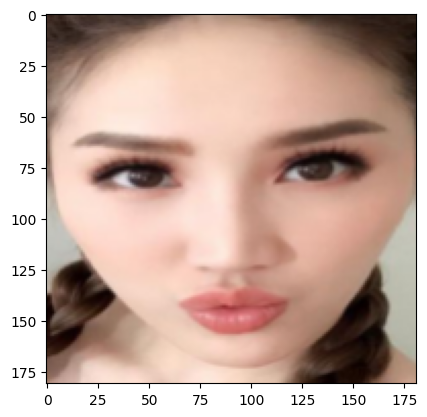

In [ ]:
id_list = neighbors.tolist()[0]
from matplotlib import pyplot as plt
for i in id_list:
    im  = plt.imread("train/"+filename[i])
    plt.imshow(im)
    plt.show()

In [ ]:
distances

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

In [ ]:
index

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x0000026DF8B54300> >